In [2]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ROOT

from root_pandas import read_root, to_root

from xgboost import XGBClassifier, plot_importance
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

from uncertainties import ufloat

In [53]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

In [4]:
bdt_df = read_root('./data/bdt-selection-run1.root')

In [5]:
classic_df = read_root('./data/classic-selection-run1.root')

In [6]:
electron_df = read_root('./data/electron-classic-run1.root')

In [7]:
kaon_df = read_root('./data/kaon-classic-run1.root')

In [8]:
for df in [bdt_df, classic_df, electron_df, kaon_df]:
    df['event_id'] = df.runNumber.apply(str) + '_' + df.eventNumber.apply(str)

In [9]:
d2total = ufloat(((1 - 2 * bdt_df.calib_proba) ** 2).sum(), np.sqrt(((1 - 2 * bdt_df.calib_proba) ** 2).sum()))

### BDT $\mu$ vs classic $\mu$

In [10]:
bdt_same = bdt_df[bdt_df.event_id.isin(classic_df.event_id)]

In [11]:
num_same = ufloat((bdt_same.__array_index == classic_df.__array_index).sum(), np.sqrt(len(classic_df)))
num_total = ufloat(len(classic_df), np.sqrt(len(classic_df)))
same_weighted = ufloat(((1 - 2 * bdt_same.calib_proba)**2 * bdt_same.SigYield_sw * (bdt_same.tp_partP == classic_df.tp_partP)).sum(),
                       np.sqrt(((1 - 2 * bdt_same.calib_proba)**2 * bdt_same.SigYield_sw).sum()))

In [12]:
print(100 * num_same / num_total)
print(100 * same_weighted / num_total)
print(100 * same_weighted / d2total)

98.3+/-0.5
14.42+/-0.16
71.9+/-1.0


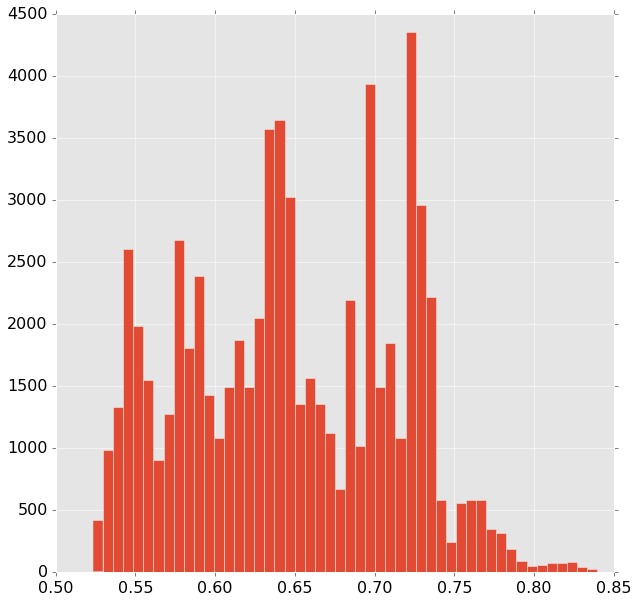

In [13]:
bdt_same.proba.hist(bins=50)

In [14]:
((1 - 2 * bdt_df.calib_proba) ** 2).sum() / len(bdt_df) * 100

1.1279090601681392

### BDT $\mu$ vs classic $e^-$

In [15]:
e_same = bdt_df[bdt_df.event_id.isin(electron_df.event_id)]
e_same_in_electron = electron_df[electron_df.event_id.isin(bdt_df.event_id)]

In [16]:
len(e_same) / len(bdt_df)

0.0243957850119908

In [17]:
num_same = ufloat((e_same.tp_partP == electron_df.tp_partP).sum(), np.sqrt(len(electron_df)))
num_total = ufloat(len(electron_df), np.sqrt(len(electron_df)))
same_weighted = ufloat(((1 - 2 * e_same.calib_proba)**2 * e_same.SigYield_sw * (e_same.tp_partP == electron_df.tp_partP)).sum(),
                       np.sqrt(((1 - 2 * e_same.calib_proba)**2 * e_same.SigYield_sw).sum()))

In [18]:
print(100 * num_same / num_total)
print(100 * same_weighted / num_total)
print(100 * same_weighted / d2total)

76.2+/-0.7
1.36+/-0.08
2.93+/-0.18


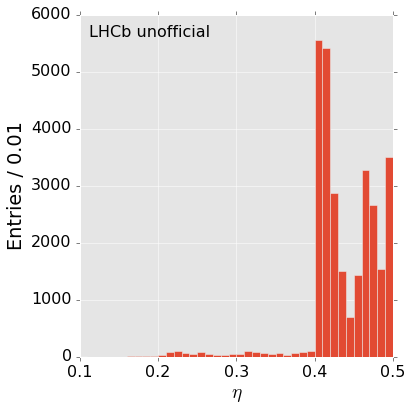

In [51]:
plt.figure(figsize=(6, 6))
etas = e_same.calib_proba.where(e_same.calib_proba < 0.5, 1 - e_same.calib_proba)
_, bins, _ = plt.hist(etas, bins=40, range=(0.1, 0.5))
binwidth = bins[1] - bins[0]
plt.xlabel(r'$\eta$')
plt.ylabel('Entries / {:.2f}'.format(binwidth))
plt.text(0.03, 0.97, 'LHCb unofficial', ha='left', va='top', transform=plt.gca().transAxes)
plt.locator_params(axis='x', nbins=6)
plt.tight_layout()
plt.savefig('build/electron-same-etas.pdf', bbox_inches='tight')
plt.show()

In [20]:
((1 - 2 * bdt_df[~bdt_df.tp_partP.isin(electron_df.tp_partP)].calib_proba) ** 2).sum() / len(bdt_df) * 100

1.0872562108962522

### BDT $\mu$ vs $K^+$

In [21]:
k_same = bdt_df[bdt_df.event_id.isin(kaon_df.event_id)]
k_same_in_electron = kaon_df[kaon_df.event_id.isin(bdt_df.event_id)]

In [22]:
len(k_same) / len(bdt_df)

0.1458940938333492

In [23]:
num_same = ufloat((k_same.tp_partP == kaon_df.tp_partP).sum(), np.sqrt(len(kaon_df)))
num_total = ufloat(len(kaon_df), np.sqrt(len(kaon_df)))
same_weighted = ufloat(((1 - 2 * k_same.calib_proba)**2 * k_same.SigYield_sw * (k_same.tp_partP == kaon_df.tp_partP)).sum(),
                       np.sqrt(((1 - 2 * k_same.calib_proba)**2 * k_same.SigYield_sw).sum()))

In [24]:
print(100 * num_same / num_total)
print(100 * same_weighted / num_total)
print(100 * same_weighted / d2total)

0.72+/-0.24
0.004+/-0.026
0.05+/-0.33


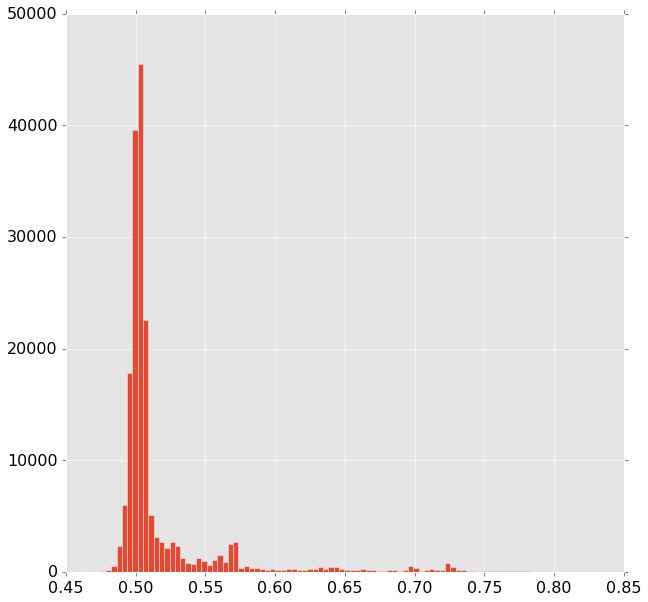

0.52+/-0.04


In [25]:
k_same.proba.hist(bins=100)
plt.show()
print(ufloat(k_same.proba.mean(), k_same.proba.std()))

In [26]:
((1 - 2 * bdt_df[~bdt_df.tp_partP.isin(kaon_df.tp_partP)].calib_proba) ** 2).sum() / len(bdt_df) * 100

1.0917090936960332

### Overlap classic $K^+$ vs $e^-$

In [27]:
same_in_k = kaon_df[kaon_df.event_id.isin(electron_df.event_id)]
same_in_e = electron_df[electron_df.event_id.isin(kaon_df.event_id)]

In [28]:
num_same_event = ufloat(len(same_in_k), np.sqrt(len(same_in_k)))
num_same = ufloat((same_in_k.tp_partP == same_in_e.tp_partP).sum(), np.sqrt(len(same_in_k)))
num_total_k = ufloat(len(kaon_df), np.sqrt(len(kaon_df)))
num_total_e = ufloat(len(electron_df), np.sqrt(len(electron_df)))

In [29]:
print('Fraction of same events in k:'.ljust(40), '{:^6}'.format(100 * num_same_event / num_total_k))
print('Fraction of same events in e:'.ljust(40), '{:^6}'.format(100 * num_same_event / num_total_e))
print('Fraction of same tagging particles in k:'.ljust(40), '{:^6}'.format(100 * num_same / num_total_k))
print('Fraction of same tagging particles in e:'.ljust(40), '{:^6}'.format(100 * num_same / num_total_e))

Fraction of same events in k:             3.70 +/- 0.05 
Fraction of same events in e:            22.13 +/- 0.30 
Fraction of same tagging particles in k:  0.43 +/- 0.05 
Fraction of same tagging particles in e:  2.57 +/- 0.27 


## How different is Run1 vs Run2 data?

In [30]:
bdt_run2 = read_root('./data/bdt-selection-run2.root')

In [31]:
bdt_df['run'] = 1
bdt_run2['run'] = 2

In [32]:
# equal number of events from both sets
indices = np.arange(len(bdt_df))
np.random.shuffle(indices)

In [33]:
bdt_df = bdt_df.iloc[indices[:len(bdt_run2)]]

In [34]:
df = pd.concat([bdt_df, bdt_run2])

In [35]:
# this is the list of BDT variables formerly used
MVA_features = [
    'tp_partP',
    'tp_partPt',
    'tp_IPPU',
    'tp_ghostProb',
    'tp_PIDNNm',
    'tp_ABS_RecVertexIP',
    'tp_mult',
    'tp_ptB',
    'tp_IPs',
    'tp_partlcs',
    'tp_PROBNNpi',
    'tp_PROBNNk',
    'tp_PROBNNp',
    'tp_PROBNNe',
]

In [36]:
train_df, test_df = train_test_split(df, test_size=0.5)

In [37]:
model = XGBClassifier(max_depth=5, n_estimators=300, nthread=12)

In [38]:
model.fit(train_df[MVA_features], train_df.run)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=300, nthread=12,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [39]:
b = model.booster()

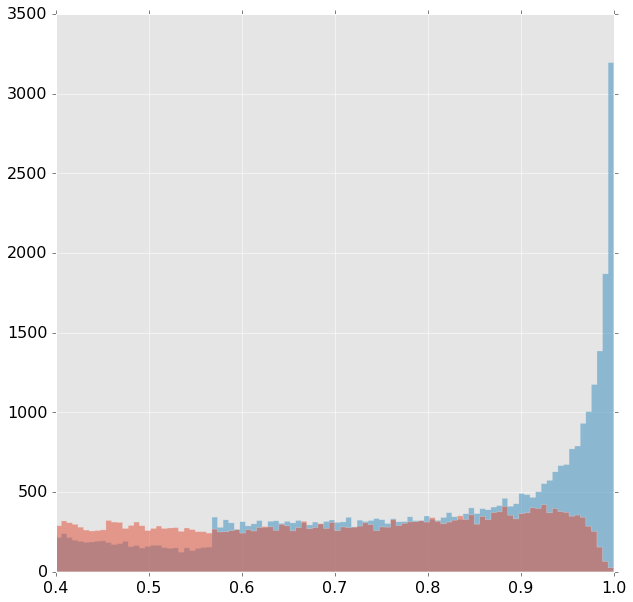

In [40]:
plt.hist([bdt_df.tp_PIDNNm, bdt_run2.tp_PIDNNm], bins=100, histtype='stepfilled', alpha=0.5, range=(0.4, 1))
plt.show()

In [41]:
b.get_fscore()

{'tp_ABS_RecVertexIP': 693,
 'tp_IPPU': 344,
 'tp_IPs': 581,
 'tp_PIDNNm': 498,
 'tp_PROBNNe': 697,
 'tp_PROBNNk': 516,
 'tp_PROBNNp': 408,
 'tp_PROBNNpi': 609,
 'tp_ghostProb': 1279,
 'tp_mult': 285,
 'tp_partP': 590,
 'tp_partPt': 656,
 'tp_partlcs': 436,
 'tp_ptB': 99}

In [42]:
probas = model.predict_proba(test_df[MVA_features])
probas_train = model.predict_proba(train_df[MVA_features])

In [43]:
test_score = roc_auc_score(test_df.run == 2, probas[:, 1])

In [44]:
fpr, tpr, _ = roc_curve(test_df.run == 2, probas[:, 1])
fpr_train, tpr_train, _ = roc_curve(train_df.run == 2, probas_train[:, 1])

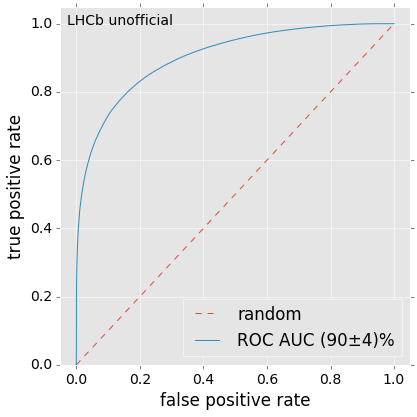

In [55]:
plt.figure(figsize=(6, 6))
plt.plot([0, 1], '--', label='random')
plt.plot(fpr, tpr, label=u'ROC AUC (90±4)%'.format(100 * test_score))
# plt.plot(fpr_train, tpr_train, label='ROC curve (train)', alpha=0.5)
plt.xlim(-0.05, 1.05)
plt.ylim(0, 1.05)
plt.legend(loc='best')
plt.xlabel(r'false positive rate')
plt.ylabel(r'true positive rate')
plt.text(0.02, 0.98, 'LHCb unofficial', ha='left', va='top', transform=plt.gca().transAxes)
plt.tight_layout()
plt.savefig('./build/roc_curve_run1_run2.pdf', bbox_inches='tight')
plt.show()

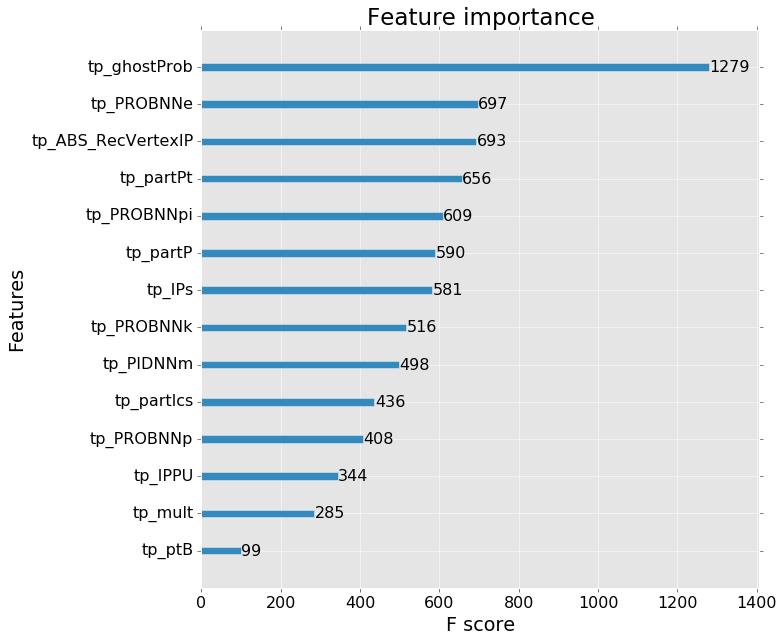

In [46]:
plot_importance(model)
plt.show()

In [44]:
score = cross_val_score(model, df[MVA_features], df.run == 1, scoring='roc_auc', n_jobs=1, cv=30, verbose=1)

KeyboardInterrupt: 

In [ ]:
print(100 * ufloat(score.mean(), score.std()))